Requires notebook 0.

In [1]:
suppressPackageStartupMessages({
  library(dataorganizer)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

ℹ Loading cellAdmixNotebooks


In [2]:
data <- prepare_gut_tx_and_meta()

In [3]:
sc_obj <- prepare_gut_scrna()

In [4]:
table(sc_obj$cell_type)


Enterocyte     Goblet     Paneth  Stem + TA       Tuft 
       572        909        203       1416         80 

In [5]:
# load gut data
data <- prepare_gut_tx_and_meta()
cell_annot <- data[[1]]
df <- data[[2]]
sc_obj <- prepare_gut_scrna()

# load pre-computed markers list
markers <- load_markers_gut()
admix_markers <- markers$gene[markers$marker_of=='Enterocyte']

## subset data to genes and cell types present in both
# subset genes
g_both <- intersect(unique(df$gene), rownames(sc_obj))
df <- df[df$gene %in% g_both,]
sc_obj <- CreateSeuratObject(sc_obj[['RNA']]$counts[g_both,], meta.data=sc_obj@meta.data)

# subset cell types
ct_both <- intersect(unique(sc_obj$cell_type),unique(cell_annot$celltype))
cell_annot <- cell_annot[cell_annot$celltype %in% ct_both,]
df <- df[df$celltype %in% ct_both,]
cells_keep <- colnames(sc_obj)[sc_obj$cell_type %in% ct_both]
sc_obj <- subset(sc_obj, cells=cells_keep)

cell_annot <- cell_annot %$% setNames(celltype, cell)

In [6]:
### now downsample spatial to match lib sizes in sc
# make spatial counts seurat object
so_spat <- get_counts_meta_seurat(df)
spat_dsamp <- downsample_spat(so_spat,sc_obj)
spat_dsamp_melt <- transform_sc(spat_dsamp)
spat_dsamp_melt$is_admixture <- spat_dsamp_melt$gene %in% admix_markers
d_st <- spat_dsamp_melt %$% estimateAdmixtureFractions(cell, is_admixture, breaks=c(0.05, 0.10, 0.2, 1)) %>%
  mutate(cell_type=cell_annot[cell])

[1] "Number of cells that had lib sizes downsampled:"
    Goblet  Stem + TA Enterocyte     Paneth       Tuft 
       356       1062       2539         50         19 


Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Normalizing layer: counts



In [7]:
# process sc data into same format
sc_melt <- transform_sc(sc_obj)
sc_melt$is_admixture <- sc_melt$gene %in% admix_markers
sc_obj@meta.data$cell <- rownames(sc_obj@meta.data)
sc_obj@meta.data$cell_type <- as.character(sc_obj@meta.data$cell_type)
sc_cell_annot <- sc_obj@meta.data %$% setNames(cell_type, cell)
d_sc <- sc_melt %$% estimateAdmixtureFractions(cell, is_admixture, breaks=c(0.05, 0.10, 0.2, 1)) %>%
  mutate(cell_type=sc_cell_annot[cell])

In [8]:
# compute admixture fractions from marker genes
p_df <- list(ST=d_st, scRNA=d_sc) %>% estimateAdmixtureComparisonDf()

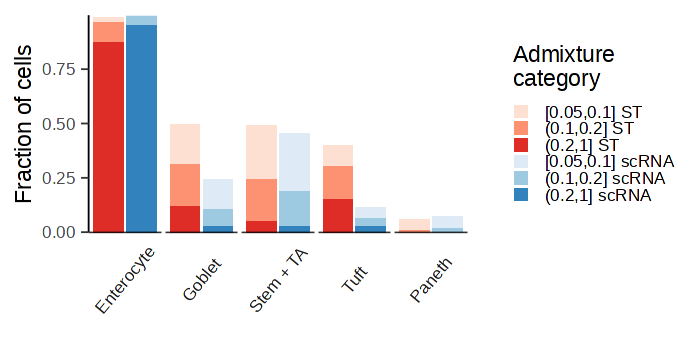

In [9]:
options(repr.plot.width = 3.5, repr.plot.height = 1.75, repr.plot.res = 200)
p <- plotAdmixtureComparison(p_df)
p

In [10]:
pdf(OutputPath("gut_prevalence_dsamp.pdf"), useDingbats = FALSE, width = 3.5, height = 1.75)
p
dev.off()

png 
  2

In [11]:
## now testing scaling the admix markers fractions down to match malignant sc
# reload the non-downsampled spatial data
so_spat_counts <- so_spat[['RNA']]$counts
so_spat_fracs <- sweep(so_spat_counts,MARGIN=2,STATS=colSums(so_spat_counts),'/')

sc_counts <- sc_obj[['RNA']]$counts
sc_fracs <- sweep(sc_counts,MARGIN=2,STATS=colSums(sc_counts),'/')

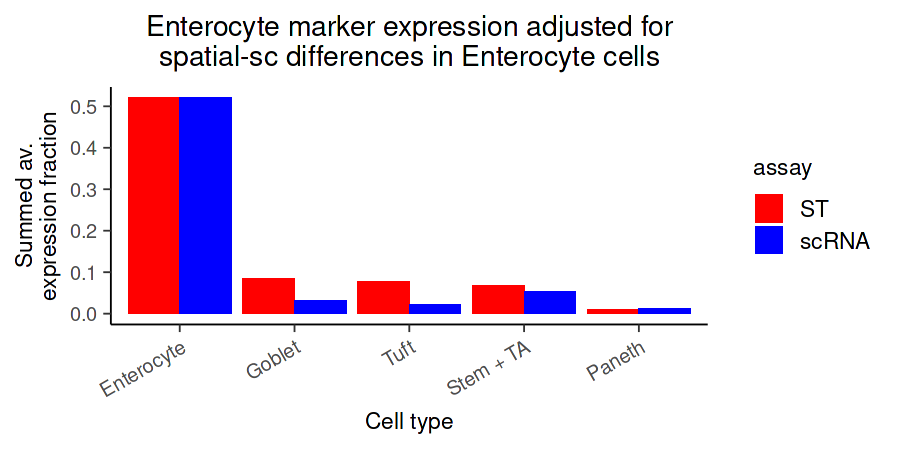

In [12]:
options(repr.plot.width = 4.5, repr.plot.height = 2.25, repr.plot.res = 200)
p2 <- plotAdmixtureCorrected(so_spat_fracs,sc_fracs,source_ct='Enterocyte')
p2

In [13]:
pdf(OutputPath("gut_mark_fracs_dsamp.pdf"), useDingbats=FALSE, width = 4.5, height = 2.25)
p2
dev.off()

png 
  2